# Continuous Bag of Words (CBOW) Implementation
## as part of Udacity Deep Learning Course

In [1]:
#Imports

import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
from matplotlib import pylab
from sklearn.manifold import TSNE

In [2]:
#Load Dataset and split into words
# 'text8' dataset from http://mattmahoney.net/dc/

with open('text8') as f:
    words = tf.compat.as_str(f.read()).split()

In [3]:
#Build the dictionary and replace rare words with UNK token.

vocab_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocab_size - 1))
    dictionary = dict()
    for word,_ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count+=1
        data.append(index)
    count[0][1] = unk_count
    reverse_dict = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dict

data, count, dictionary, reverse_dict = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words


Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [4]:
#%%  Function to generate batches for CBOW model

data_index = 0
def gen_batch(batch_size, skip_window):
    global data_index
    assert skip_window%2==1
    span = 2*skip_window + 1
    batch = np.ndarray(shape=(batch_size,span-1), dtype = np.int32)
    labels = np.ndarray(shape=(batch_size,1), dtype = np.int32)
    buffer = collections.deque(maxlen = span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index+1) % len(data)
    
    for i in range(batch_size):
        target = skip_window
        col_idx=0
        for j in range(span):
            if j==span//2:
                continue
            batch[i,col_idx] = buffer[j]
            col_idx+=1
        labels[i,0] = buffer[target]

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    assert batch.shape[0]==batch_size and batch.shape[1]==span-1
    return batch, labels

In [5]:
#%%  TF Model

batch_size = 128
embedding_size = 128
skip_window = 3
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples, random.sample(range(1000,1000+valid_window), valid_size//2))
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    #Input
    train_dataset = tf.placeholder(tf.int32, shape = [batch_size, 2*skip_window])
    train_labels = tf.placeholder(tf.int32, shape = [batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype = tf.int32)
    
    #Variables
    embeddings = tf.Variable(tf.random_uniform([vocab_size,embedding_size],-1.0,1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocab_size, embedding_size], stddev=1.0/math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocab_size]))
    
    #Model
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)

    embed = None
    for i in range(2*skip_window):
        ecurr = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])
        embx, emby = ecurr.get_shape().as_list()
        if embed is None:
            embed = tf.reshape(ecurr, [embx, emby,1])
        else:
            embed = tf.concat([embed, tf.reshape(ecurr, [embx, emby,1])], 2)

    assert embed.get_shape().as_list()[2]==2*skip_window
    avg_embed = tf.reduce_mean(embed,2,keep_dims=False)

    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights = softmax_weights, biases = softmax_biases, inputs = avg_embed, labels = train_labels, num_sampled = num_sampled, num_classes = vocab_size))
    
    #optimizer
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
    

In [6]:
#%% Session
    
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    avg_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = gen_batch(batch_size, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict = feed_dict)
        avg_loss += l
        if step%2000==0 and step>0:
            avg_loss = avg_loss/2000
            print('Average loss at step %d: %f' % (step, avg_loss))
            avg_loss = 0
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dict[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dict[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()
    

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Nearest to some: propeller, manufactured, jaspers, monitored, amidah, sable, gates, neurologists,
Nearest to five: electromotive, pentium, foothold, anglo, dolby, duff, strumming, busts,
Nearest to this: integrated, whitfield, mcvie, ayers, floated, mallory, documenting, jonah,
Nearest to had: propulsion, ary, consul, refuting, arrows, enhancements, march, illustrate,
Nearest to people: silicate, forerunner, conte, kingfishers, bengals, gime, governing, temperature,
Nearest to has: attentive, movable, uneven, empedocles, truso, cemeteries, altair, lynne,
Nearest to to: darfur, technologies, iguana, complain, asn, roche, hardships, racing,
Nearest to these: demoscene, pigment, counselling, tagalog, luis, unspoken, berman, deified,
Nearest to not: collated, fgc, koala, ucla, males, cruciform, snowmobiles, fingering,
Nearest to about: cultic, antimony, voiceover, y, goodness, capybara, media, coronation,

Average loss at step 52000: 3.164342
Average loss at step 54000: 3.197711
Average loss at step 56000: 3.089280
Average loss at step 58000: 3.156305
Average loss at step 60000: 3.133047
Nearest to some: many, several, various, all, most, dcc, none, these,
Nearest to five: four, six, seven, three, eight, zero, million, two,
Nearest to this: it, which, what, the, consequentialism, gestalt, transfiguration, any,
Nearest to had: has, have, having, was, were, gundam, diarrhoea, took,
Nearest to people: those, children, nations, karzai, elliott, complicates, musicians, scrupulous,
Nearest to has: had, have, having, includes, is, was, monarchists, contains,
Nearest to to: will, could, would, let, turntable, bem, iguana, might,
Nearest to these: certain, different, other, they, counselling, many, bound, various,
Nearest to not: collated, never, koala, cations, franciscan, fgc, gliders, males,
Nearest to about: how, easter, mamadou, unionist, gynt, capybara, scanline, benefited,
Nearest to nine:

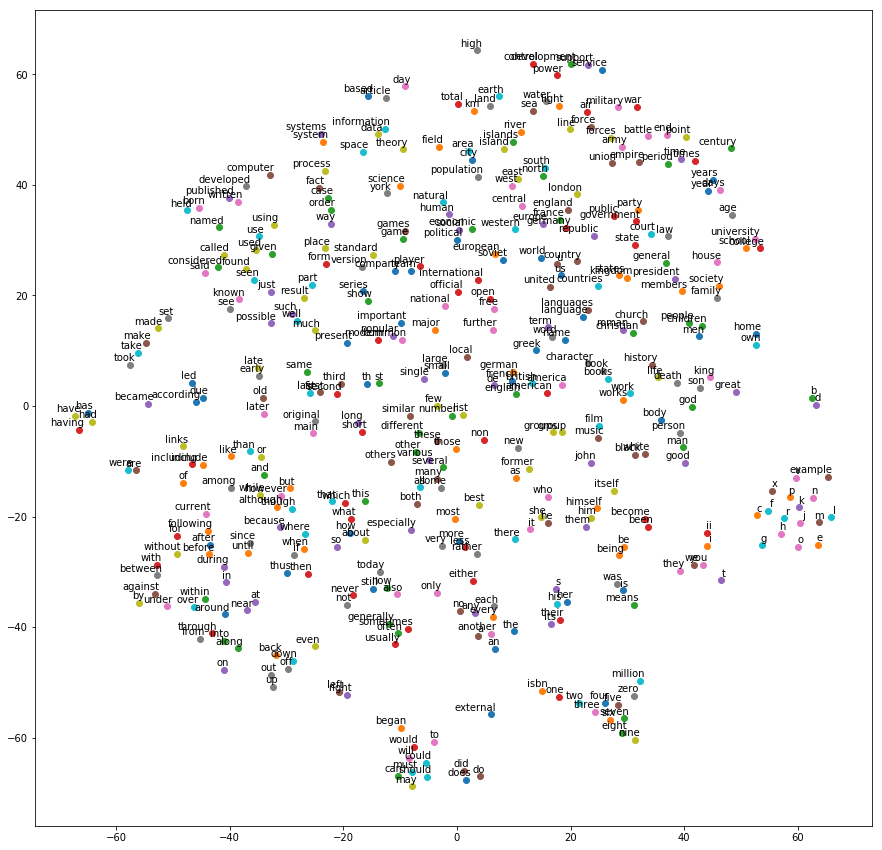

In [7]:
#%% Visualization using TSNE

num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dict[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)